In [ ]:
"""
The approach outlined in this docstring is not valid any more. Directly
jump to the heading "Two-Tailed Evaluation With Four Hit Lists".

The purpose of this Jupyter notebook is to perform an alternative
evaluation of xCAPT5 performance.

To be more precise, the alternative evaluation differs from the previous
one in that it is two-tailed. That means that the previous evaluation
only classified extraordinarily high intensities as hits, whereas the
alternative evaluation takes both extraordinarily high and
extraordinarily low intensities into account. This makes sense insofar
as both extremes are indicative of genes/proteins potentially having a
role in the VACV life cycle (proteins the knockdown of which is
associated with extraordinarily high intensities presumably hamper VACV
replication; conversely, proteins the knockdown of which is associated
with extraordinarily low intensites presumably promote/faciliate VACV
replication, i.e. they serve as host factors hijacked by VACV).

The procedure by which both intensity extremes are taken into account is
as follows: Since the intensity values have been min-max normalized,
they are in a [0, 1] range. Leveraging this fact, the
"counter-intensities" can be computed by simply subtracting the original
intensity from 1. For each intensity measurement, the maximum value
between original intensity and "counter-intensity" is chosen. These
maximum values are then subjected to PPI-guided refinement (via maximum,
mean, median and sum refinement mode). Following this, performance
evaluation across different thresholds is performed as usual via ROC
curves.

The reason this approach is pursued is that clear information on the
role of individual human proteins/genes in the VACV life cycle is not
always available.
"""

'\nThe purpose of this Jupyter notebook is to perform an alternative\nevaluation of xCAPT5 performance.\n\nTo be more precise, the alternative evaluation differs from the previous\none in that it is two-tailed. That means that the previous evaluation\nonly classified extraordinarily high intensities as hits, whereas the\nalternative evaluation takes both extraordinarily high and\nextraordinarily low intensities into account. This makes sense insofar\nas both extremes are indicative of genes/proteins potentially having a\nrole in the VACV life cycle (proteins the knockdown of which is\nassociated with extraordinarily high intensities presumably hamper VACV\nreplication; conversely, proteins the knockdown of which is associated\nwith extraordinarily low intensites presumably promote/faciliate VACV\nreplication, i.e. they serve as host factors hijacked by VACV).\n\nThe procedure by which both intensity extremes are taken into account is\nas follows: Since the intensity values have been mi

In [1]:
import math
import os

import pandas as pd
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

### Load the Intensity Values

In [2]:
refinement_modes = ["max", "mean", "median", "sum"]

# Of all measurement types, "VoronoiCells" turned out to exhibit the
# least variance
# Thus, the corresponding columns (early and late) are extracted from
# the individual DataFrames
feature_names_unnormalized = [
    "dIntensity_cPathogen_eMean_oVoronoiCells",
    "dIntensity_cLatePathogen_eMean_oVoronoiCells"
]

feature_names_normalized = [
    "dIntensity_cPathogen_eMean_oVoronoiCells_nZScore",
    "dIntensity_cLatePathogen_eMean_oVoronoiCells_nZScore"
]

In [3]:
# Load the unnormalized min-max normalized intensities
path_unnorm_min_max_norm_ints = (
    "refined_intensities_and_related_data/unnorm_intensities_min-max_"
    "normalized.tsv"
)

unnorm_min_max_norm_ints_df = pd.read_csv(
    path_unnorm_min_max_norm_ints,
    sep="\t",
    usecols=["Name", "UniProt_IDs"] + feature_names_unnormalized,
    index_col=["Name", "UniProt_IDs"]
)

# Load the IQM-normalized min-max normalized intensities
path_iqm_norm_min_max_norm_ints = (
    "refined_intensities_and_related_data/IQM-normalized_intensities_"
    "min-max_normalized.tsv"
)

iqm_norm_min_max_norm_ints_df = pd.read_csv(
    path_iqm_norm_min_max_norm_ints,
    sep="\t",
    usecols=["Name", "UniProt_IDs"] + feature_names_normalized,
    index_col=["Name", "UniProt_IDs"]
)

### Take Both Extremes into Account

In [ ]:
# Now, for each DataFrame, take both intensity extremes into account via
# the approach outlined in the docstring
# For the sake of convenience, define a function performing the
# intensity processing
def consider_both_extremes(int_df, feature_list):
    """
    Take both intensity extremes into account.

    Specifically, this is done in the following manner: ...

    Parameters
    ----------
    int_df: Pandas DataFrame
        A Pandas DataFrame to apply the procedure on.
    feature_list: list
        A list containing the features in `int_df` for which to perform
        the procedure.

    Returns
    -------
    processed_int_df: Pandas DataFrame
        The input DataFrame with intensities that have undergone the
        procedure.
    """

    # Copy the input DataFrame so as to leave it unaltered
    processed_int_df = int_df.copy()

    for feature in feature_list:
        feature_sub_df = int_df[[feature]]
        # Add a column with "counter-intensities"
        feature_sub_df[feature + "_counter"] = 1 - feature_sub_df[feature]
        
        # For each row, determine the maximum intensity and overwrite
        # the input DataFrame with the corresponding values
        processed_int_df[feature] = feature_sub_df.max(axis=1).to_numpy()

    return processed_int_df

In [ ]:
unnorm_min_max_norm_ints_df = consider_both_extremes(
    unnorm_min_max_norm_ints_df,
    feature_names_unnormalized
)

iqm_norm_min_max_norm_ints_df = consider_both_extremes(
    iqm_norm_min_max_norm_ints_df,
    feature_names_normalized
)

In [ ]:
# Create a directory to store the intensities in
refined_ints_dir = "refined_intensities_and_related_data"
both_extremes_ints_dir = "alternative_evaluation_with_both_extremes"

both_extremes_path = os.path.join(
    refined_ints_dir,
    both_extremes_ints_dir
)

if not os.path.exists(both_extremes_path):
    os.makedirs(both_extremes_path)

In [ ]:
# Save the two intensity DataFrames to TSV files
unnorm_min_max_norm_ints_df.to_csv(
    os.path.join(
        both_extremes_path,
        "unnormalized_intensities_min-max_normalized.tsv"
    ),
    sep="\t"
)

iqm_norm_min_max_norm_ints_df.to_csv(
    os.path.join(
        both_extremes_path,
        "IQM-normalized_intensities_min-max_normalized.tsv"
    ),
    sep="\t"
)

### Perform PPI-Guided Intensity Refinement

In [ ]:
# Now that both intensity extremes have been taken into account,
# PPI-guided intensity refinement is performed via the four refinement
# modes (max, mean, median, sum)
# To this end, the PPI summary statistics are loaded into a DataFrame
ppi_prob_summary_stats_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/refined_intensities_and_related_data/"
    "PPI_probabilities_summary_statistics.tsv"
)

ppi_prob_summary_stats_df = pd.read_csv(
    ppi_prob_summary_stats_path,
    sep="\t",
    index_col="human_prot"
)

In [21]:
# The arguably most convenient way of performing the refinement
# (multiplication by maximum, mean, etc.) consists of extracting the
# refinement factors in the order of the UniProt accessions and to
# simply perform the multiplication using Pandas vectorization

# For the sake of convenience, define a function bundling the steps of
# refinement multiplication, min-max normalization and file saving under
# the hood
def refine_intensities(
        intensity_df, summary_stats_df, refinement_mode, output_path,
        min_max_norm=True
):
    """
    Refines the intensities stored in `intensity_df` using the summary
    statistics deposited in `summary_stats_df` and saves the resulting
    DataFrame at the location specified by `output_path`.

    `intensity_df` is expected to have a MultiIndex with two levels. One
    level is expected to store gene names, whereas the second level
    should store UniProt accessions. The level storing UniProt
    accessions must bear the name "UniProt_IDs".

    `summary_stats_df` is expected to contain four columns, which are
    `max`, `mean`, `median` as well as `sum`. Its index is expected to
    consist of UniProt accessions.

    Accordingly, four different summary statistics can be used for the
    first step, i.e. the refinement step, which are "max", "mean",
    "median" and "sum". The summary statistics to use is specified by
    passing the corresponding string as argument to `refinement_mode`.

    The second step, i.e. the min-max normalization, is performed for
    each column in `intensity_df` individually, i.e. the minimum and
    maximum values are determined for each column separately and also
    exclusively applied to the respective column. Conveniently enough,
    Pandas's `.min()` and `.max()` methods operate on a per column basis
    by default, so no special measures must be taken to ensure
    column-wise normalization. Note that the min-max normalization step
    can optionally be switched off.

    Parameters
    ----------
    intensity_df: Pandas DataFrame
        Pandas DataFrame containing the intensity data to perform the
        refinement and normalization on.
    summary_stats_df: Pandas DataFrame
        Pandas DataFrame listing for each UniProt accessions the
        maximum, the mean, the median and the sum of the predicted PPI
        probabilities.
    refinement_mode: str
        A string denoting which of the summary statistics to use for the
        refinement (maximum, mean, median or sum).
    output_path: str
        A string denoting the location to save the resulting DataFrame
        at.
    min_max_norm: Boolean, optional
        A Boolean indicating whether min-max normalization is to be
        applied or not. Defaults to `True`.

    Returns
    -------
    refined_intensity_df: Pandas DataFrame
        DataFrame containing the refined and normalized intensities.
    """
    
    # Extract the UniProt accessions from the MultiIndex in
    # `intensity_df`
    # This is necessary for the extraction of the refinement factors
    # (summary statistics stored in `summary_stats_df`)
    uniprot_accs = intensity_df.index.get_level_values("UniProt_IDs")

    refinement_factors = summary_stats_df[refinement_mode].loc[
        uniprot_accs
    ].to_numpy()

    # Perform the first step, i.e. the multiplication by the refinement
    # factors
    # In order to ensure that multiplication is performed in a row-wise
    # manner, the `.mul()` method is used in conjunction with the `axis`
    # parameter
    refined_intensity_df = intensity_df.mul(
        refinement_factors,
        axis=0
    )

    # Now, address the second step, i.e. the conversion of the refined
    # intensities to a [0, 1] range
    # This is accomplished by means of min-max normalization, which uses
    # the following formula: (x - x_{min}) / (x_{max} - x_{min})
    # Min-max normalization is supposed to be applied for each column
    # individually
    # Conveniently enough, Pandas's `.min()` and `.max()` methods
    # operate on a per column basis by default, so no special measures
    # must be taken to ensure column-wise normalization
    # This step is optional
    if min_max_norm:
        refined_intensity_df = (
            (refined_intensity_df - refined_intensity_df.min())
            /
            (refined_intensity_df.max() - refined_intensity_df.min())
        )

    # Save the DataFrame to a TSV file at the location specified by
    # `output_path`
    refined_intensity_df.to_csv(
        output_path,
        sep="\t",
        index=True
    )

    return refined_intensity_df

#### Performing the Refinement for Unnormalized Intensities

In [ ]:
# Perform the refinement via the four refinement modes (max, mean,
# median, sum)
for mode in refinement_modes:
    refine_intensities(
        unnorm_min_max_norm_ints_df,
        ppi_prob_summary_stats_df,
        mode,
        os.path.join(
            both_extremes_path,
            f"unnorm_intensities_{mode}_refined.tsv"
        ),
        min_max_norm=False
    )

#### Performing the Refinement for IQM-Normalized Intensities

In [ ]:
for mode in refinement_modes:
    refine_intensities(
        iqm_norm_min_max_norm_ints_df,
        ppi_prob_summary_stats_df,
        mode,
        os.path.join(
            both_extremes_path,
            f"IQM-normalized_intensities_{mode}_refined.tsv"
        )
    )

### Performance Evaluation

In [23]:
def round_half_up(unrounded_num, decimal_place=0):
    """
    Performs half up rounding on the provided input on the specified
    decimal place, i.e. if the value in the decimal place to the right
    of the specified decimal place is greater than or equal to 5,
    rounding up is performed. Conversely, if the value is less than 5,
    rounding down is performed.

    This is accomplished in three steps. The first step consists of
    shifting the decimal point by the desired number of places. The
    second step involves adding 0.5 and the subsequent usage of
    `math.floor()`. Lastly, the third step shifts the decimal point back
    to the original position.

    Parameters
    ----------
    unrounded_num: int or float
        The input number to perform half up rounding on.
    decimal_place: int, optional
        The decimal place to perform rounding on.

    Returns
    -------
    rounded_num: float
        The input number after half up rounding on the specified decimal
        place.
    """

    # First step, i.e. shifting the decimal point by the desired number
    # of places
    unrounded_num *= 10**decimal_place

    # Second step, i.e. addition of 0.5 and subsequent usage of
    # `math.floor()`
    unrounded_num += 0.5
    shifted_and_rounded_num = math.floor(unrounded_num)

    # Third step, i.e. shifting the decimal point back to the original
    # position
    rounded_num = shifted_and_rounded_num * 10**(-decimal_place)

    return rounded_num

In [24]:
# For the sake of convenience, define a function plotting the ROC AUC
# curves
def generate_ROC_curve(
        intensity_df, ground_truth_df, feature_list, title_info,
        image_dir
):
    """
    Generates ROC AUC curves for selected features/columns in
    `intensity_df`.
    
    Parameters
    ----------
    intensity_df: Pandas DataFrame
        A Pandas DataFrame storing the normalized intensities, i.e. the
        probabilities of a protein being involved in a PPI. The
        DataFrame is expected to have a MultiIndex with two levels, one
        of them being `Name` and the other being `UniProt_IDs`.
    ground_truth_df: Pandas DataFrame
        A Pandas DataFrame storing the ground truth labels. The
        DataFrame is expected to have UniProt accessions as its index.
    feature_list: list
        A list containing the features in `intensity_df` for which an
        ROC AUC curve is generated each.
    title_info: str
        A string providing details about how the probabilities were
        obtained. It appears in the figure title.
    image_dir: str
        A string denoting the directory in which to store the images.

    Returns
    -------
    roc_auc_score_and_curve_df_list: list
        A list containing the ROC AUC score as well as the curve data
        for each feature listed in `feature_list`, i.e. the list's
        length equals the length of `feature_list`. In detail, the curve
        data is a Pandas DataFrame comprising three columns, the first
        of which contains the False Positive Rate, the second which
        stores the True Positive Rate and the third of which stores the
        threshold.
    """
    # `intensity_df` does not necessarily exclusively contain instances
    # present in `ground_truth_df`
    # Thus, the DataFrame has to be filtered to contain exclusively
    # proteins present in the ground truth DataFrame
    filtered_intensity_df = intensity_df[
        intensity_df
        .index
        .get_level_values("UniProt_IDs")
        .isin(ground_truth_df.index)
    ]

    # Extract the ground truth labels
    # To this end, convenient indexing via the index labels is
    # capitalized on
    ground_truth_arr = ground_truth_df.loc[
        filtered_intensity_df.index.get_level_values("UniProt_IDs"),
        "Label"
    ].to_numpy()

    roc_auc_score_and_curve_df_list = []

    for feature in feature_list:
        # Extract the current feature
        ppi_probs_arr = filtered_intensity_df[feature].to_numpy()
        
        # Use the ground truth labels in conjunction with the predicted
        # probabilities so as to compute the ROC AUC score as well as
        # the FPR/TPR values
        fpr, tpr, thresholds = roc_curve(ground_truth_arr, ppi_probs_arr)
        roc_auc_score = auc(fpr, tpr)
        curve_df = pd.DataFrame(data={
            "FPR": fpr,
            "TPR": tpr,
            "Threshold": thresholds
        })
        roc_auc_score_and_curve_df_list.append([roc_auc_score, curve_df])

        # Now, turn to the generation of the ROC curves
        fig, ax = plt.subplots(1, 1)

        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(
            f"ROC curve\n({title_info},\n{feature})\n"
            f"ROC AUC score: {round_half_up(roc_auc_score, 4):.4f}"
        )

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1.05)

        # Plot the dashed diagonal line representing a random chance
        # model
        ax.plot([0, 1], [0, 1], lw=2, linestyle="--")

        # Plot the ROC curve
        ax.plot(fpr, tpr, lw=2)

        fig.savefig(
            os.path.join(
                image_dir,
                f"ROC_curve_{'_'.join(title_info.split())}_{feature}.png"
            ),
            dpi=300
        )

    return roc_auc_score_and_curve_df_list

In [ ]:
# Create a directory to store the ROC curves in
roc_curve_dir_name = "roc_curves_and_related_data"
alternative_evaluation_dir_name = "evaluation_both_extremes"

if not os.path.exists(
    os.path.join(roc_curve_dir_name, alternative_evaluation_dir_name)
):
    os.makedirs(
        os.path.join(roc_curve_dir_name, alternative_evaluation_dir_name)
    )

#### Generating ROC Curves for Unnormalized and Unrefined Intensity Values

In [ ]:
# Create a directory for this type of intensities
unnorm_unrefined_ints_roc_dir = "unnormalized_unrefined_intensity_values"

if not os.path.exists(
    os.path.join(
        roc_curve_dir_name,
        alternative_evaluation_dir_name,
        unnorm_unrefined_ints_roc_dir
    )
):
    os.makedirs(
        os.path.join(
            roc_curve_dir_name,
            alternative_evaluation_dir_name,
            unnorm_unrefined_ints_roc_dir
        )
    )

In [ ]:
# Load the TSV file storing the ground truth labels into a DataFrame
# The `gene_and_protein_labels.tsv` file stores the intersection between
# the test set and the screen subset
ground_truth_tsv_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/roc_curves_and_related_data/gene_and_"
    "protein_labels.tsv"
)

prot_label_df = pd.read_csv(
    ground_truth_tsv_path,
    sep="\t",
    usecols=["UniProt_IDs", "Label"],
    index_col="UniProt_IDs"
)

In [ ]:
generate_ROC_curve(
    unnorm_min_max_norm_ints_df,
    prot_label_df,
    feature_names_unnormalized,
    "unnormalized unrefined intensities",
    os.path.join(
        roc_curve_dir_name,
        alternative_evaluation_dir_name,
        unnorm_unrefined_ints_roc_dir
    )
)

#### Generating ROC Curves for IQM-Normalized Unrefined Intensity Values

In [ ]:
# Create a directory for this type of intensities
iqm_norm_unrefined_ints_roc_dir = (
    "IQM-normalized_unrefined_intensity_values"
)

if not os.path.exists(
    os.path.join(
        roc_curve_dir_name,
        alternative_evaluation_dir_name,
        iqm_norm_unrefined_ints_roc_dir
    )
):
    os.makedirs(
        os.path.join(
            roc_curve_dir_name,
            alternative_evaluation_dir_name,
            iqm_norm_unrefined_ints_roc_dir
        )
    )

In [ ]:
generate_ROC_curve(
    iqm_norm_min_max_norm_ints_df,
    prot_label_df,
    feature_names_normalized,
    "IQM-normalized unrefined intensities",
    os.path.join(
        roc_curve_dir_name,
        alternative_evaluation_dir_name,
        iqm_norm_unrefined_ints_roc_dir
    )
)

#### Generating ROC Curves for Unnormalized and Refined Intensity Values

In [ ]:
# Create a directory for this type of intensities
unnorm_refined_ints_roc_dir = "unnormalized_refined_intensity_values"

if not os.path.exists(
    os.path.join(
        roc_curve_dir_name,
        alternative_evaluation_dir_name,
        unnorm_refined_ints_roc_dir
    )
):
    os.makedirs(
        os.path.join(
            roc_curve_dir_name,
            alternative_evaluation_dir_name,
            unnorm_refined_ints_roc_dir
        )
    )

In [ ]:
# Load the unnormalized and PPI-refined intensity values
unnorm_ppi_refined_ints_list = []

for mode in refinement_modes:
    current_ints_path = os.path.join(
        both_extremes_path,
        f"unnorm_intensities_{mode}_refined.tsv"
    )

    current_ints_df = pd.read_csv(
        current_ints_path,
        sep="\t",
        index_col=["Name", "UniProt_IDs"]
    )

    unnorm_ppi_refined_ints_list.append(current_ints_df)

In [ ]:
# In a for loop, jointly create subdirectories and generate the ROC
# curves
for mode, intensity_df in zip(
    refinement_modes, unnorm_ppi_refined_ints_list
):
    # Subdirectory creation
    subdir_path = os.path.join(
        roc_curve_dir_name,
        alternative_evaluation_dir_name,
        unnorm_refined_ints_roc_dir,
        f"{mode}_refinement"
    )
    if not os.path.exists(subdir_path):
        os.makedirs(subdir_path)

    # ROC curve generation
    generate_ROC_curve(
        intensity_df,
        prot_label_df,
        feature_names_unnormalized,
        f"unnormalized {mode} refined intensities",
        subdir_path
    )

#### Generating ROC Curves for IQM-Normalized and Refined Intensity Values

In [ ]:
# Create a directory for this type of intensities
iqm_norm_refined_ints_roc_dir = "IQM-normalized_refined_intensity_values"

if not os.path.exists(
    os.path.join(
        roc_curve_dir_name,
        alternative_evaluation_dir_name,
        iqm_norm_refined_ints_roc_dir
    )
):
    os.makedirs(
        os.path.join(
            roc_curve_dir_name,
            alternative_evaluation_dir_name,
            iqm_norm_refined_ints_roc_dir
        )
    )

In [ ]:
# Load the IQM-normalized and PPI-refined intensity values
iqm_norm_ppi_refined_ints_list = []

for mode in refinement_modes:
    current_ints_path = os.path.join(
        both_extremes_path,
        f"IQM-normalized_intensities_{mode}_refined.tsv"
    )

    current_ints_df = pd.read_csv(
        current_ints_path,
        sep="\t",
        index_col=["Name", "UniProt_IDs"]
    )

    iqm_norm_ppi_refined_ints_list.append(current_ints_df)

In [ ]:
# In a for loop, jointly create subdirectories and generate the ROC
# curves
for mode, intensity_df in zip(
    refinement_modes, iqm_norm_ppi_refined_ints_list
):
    # Subdirectory creation
    subdir_path = os.path.join(
        roc_curve_dir_name,
        alternative_evaluation_dir_name,
        iqm_norm_refined_ints_roc_dir,
        f"{mode}_refinement"
    )
    if not os.path.exists(subdir_path):
        os.makedirs(subdir_path)
    
    # ROC curve generation
    generate_ROC_curve(
        intensity_df,
        prot_label_df,
        feature_names_normalized,
        f"IQM-normalized {mode} refined intensities",
        subdir_path
    )

## Two-Tailed Evaluation With Four Hit Lists

In [4]:
"""
Having consulted with my supervisor, it turned out that I should stick
with the original approach, i.e. the generation of four hit lists.

Specifically, I am going to obtain two hit lists for early and late
each, one of them representing high intensity hits and the other
representing low intensity hits.

High intensity hits are obtained as usual. However, in order to obtain
low intensity hits, the following procedure is performed: The complement
of the intensities is computed, i.e. 1 - intensity.

With regard to the ground truth labels, no distinction is made between
high and low intensity hits. Instead, the original intensities and their
complement are treated as different screens.
"""

'\nHaving consulted with my supervisor, it turned out that I should stick\nwith the original approach, i.e. the generation of four hit lists.\n\nSpecifically, I am going to obtain two hit lists for early and late\neach, one of them representing high intensity hits and the other\nrepresenting low intensity hits.\n\nHigh intensity hits are obtained as usual. However, in order to obtain\nlow intensity hits, the following procedure is performed: The complement\nof the intensities is computed, i.e. 1 - intensity.\n\nWith regard to the ground truth labels, no distinction is made between\nhigh and low intensity hits. Instead, the original intensities and their\ncomplement are treated as different screens.\n'

### Load the Intensity Values

In [5]:
# Load the unnormalized min-max normalized intensities
path_unnorm_min_max_norm_ints = (
    "refined_intensities_and_related_data/unnorm_intensities_min-max_"
    "normalized.tsv"
)

unnorm_min_max_norm_ints_df = pd.read_csv(
    path_unnorm_min_max_norm_ints,
    sep="\t",
    usecols=["Name", "UniProt_IDs"] + feature_names_unnormalized,
    index_col=["Name", "UniProt_IDs"]
)

# Load the IQM-normalized min-max normalized intensities
path_iqm_norm_min_max_norm_ints = (
    "refined_intensities_and_related_data/IQM-normalized_intensities_"
    "min-max_normalized.tsv"
)

iqm_norm_min_max_norm_ints_df = pd.read_csv(
    path_iqm_norm_min_max_norm_ints,
    sep="\t",
    usecols=["Name", "UniProt_IDs"] + feature_names_normalized,
    index_col=["Name", "UniProt_IDs"]
)

### Compute the Complement Intensities

In [6]:
# Create a directory to store the intensities in
refined_ints_dir = "refined_intensities_and_related_data"
four_hit_lists_approach_dir = "four_hit_lists_approach"

four_hit_lists_approach_path = os.path.join(
    refined_ints_dir,
    four_hit_lists_approach_dir
)

if not os.path.exists(four_hit_lists_approach_path):
    os.makedirs(four_hit_lists_approach_path)

In [7]:
# To compute the complement intensities, vectorized operations offered
# by Pandas are harnessed
compl_unnorm_min_max_norm_ints_df = 1 - unnorm_min_max_norm_ints_df
compl_iqm_norm_min_max_norm_ints_df = 1 - iqm_norm_min_max_norm_ints_df

In [8]:
# Save the two intensity DataFrames to TSV files
compl_unnorm_min_max_norm_ints_df.to_csv(
    os.path.join(
        four_hit_lists_approach_path,
        "complement_unnormalized_intensities_min-max_normalized.tsv"
    ),
    sep="\t"
)

compl_iqm_norm_min_max_norm_ints_df.to_csv(
    os.path.join(
        four_hit_lists_approach_path,
        "complement_IQM-normalized_intensities_min-max_normalized.tsv"
    ),
    sep="\t"
)

### Perform PPI-Guided Intensity Refinement

In [9]:
# Load the PPI summary statistics into a DataFrame
ppi_prob_summary_stats_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/refined_intensities_and_related_data/"
    "PPI_probabilities_summary_statistics.tsv"
)

ppi_prob_summary_stats_df = pd.read_csv(
    ppi_prob_summary_stats_path,
    sep="\t",
    index_col="human_prot"
)

In [10]:
# Load the complement intensities into DataFrames
compl_unnorm_min_max_norm_ints_df = pd.read_csv(
    os.path.join(
        four_hit_lists_approach_path,
        "complement_unnormalized_intensities_min-max_normalized.tsv"
    ),
    sep="\t",
    index_col=["Name", "UniProt_IDs"]
)

compl_iqm_norm_min_max_norm_ints_df = pd.read_csv(
    os.path.join(
        four_hit_lists_approach_path,
        "complement_IQM-normalized_intensities_min-max_normalized.tsv"
    ),
    sep="\t",
    index_col=["Name", "UniProt_IDs"]
)

In [22]:
# Logically, PPI-guided intensity refinement only has to be performed
# for the complementary intensities as refinement of the original
# intensites has already been performed in the very first approach

# For the sake of convenience, utilize the `refine_intensities` function
# Perform the refinement via the four refinement modes (max, mean,
# median, sum)
for mode in refinement_modes:
    # Refinement for the complement of the unnormalized min-max
    # normalized intensities
    refine_intensities(
        compl_unnorm_min_max_norm_ints_df,
        ppi_prob_summary_stats_df,
        mode,
        os.path.join(
            four_hit_lists_approach_path,
            f"complement_unnorm_intensities_{mode}_refined.tsv"
        ),
        min_max_norm=False
    )

    # Refinement for the complement of the IQM-normalized min-max
    # normalized intensities
    refine_intensities(
        compl_iqm_norm_min_max_norm_ints_df,
        ppi_prob_summary_stats_df,
        mode,
        os.path.join(
            four_hit_lists_approach_path,
            f"complement_IQM-normalized_intensities_{mode}_refined.tsv"
        ),
        min_max_norm=False
    )

### Performance Evaluation

In [25]:
# Create a directory to store the ROC curves in
roc_curve_dir_name = "roc_curves_and_related_data"

if not os.path.exists(
    os.path.join(roc_curve_dir_name, four_hit_lists_approach_dir)
):
    os.makedirs(
        os.path.join(roc_curve_dir_name, four_hit_lists_approach_dir)
    )

In [30]:
# Load the TSV file storing the ground truth labels into a DataFrame
# The `gene_and_protein_labels.tsv` file stores the intersection between
# the test set and the screen subset
ground_truth_tsv_path = (
    "/Users/jacobanter/Documents/Code/VACV_screen/Processing_Dharmacon_"
    "pooled_genome_1_and_2_subset/roc_curves_and_related_data/gene_and_"
    "protein_labels.tsv"
)

prot_label_df = pd.read_csv(
    ground_truth_tsv_path,
    sep="\t",
    usecols=["UniProt_IDs", "Label"],
    index_col="UniProt_IDs"
)

#### Generating ROC Curves for Unnormalized and Unrefined Intensity Values

In [26]:
# Create a directory for this type of intensities
unnorm_unrefined_ints_roc_dir = "unnormalized_unrefined_intensity_values"

if not os.path.exists(
    os.path.join(
        roc_curve_dir_name,
        four_hit_lists_approach_dir,
        unnorm_unrefined_ints_roc_dir
    )
):
    os.makedirs(
        os.path.join(
            roc_curve_dir_name,
            four_hit_lists_approach_dir,
            unnorm_unrefined_ints_roc_dir
        )
    )

[[0.40861344537815125,
           FPR       TPR  Threshold
  0   0.000000  0.000000        inf
  1   0.000000  0.029412   0.899073
  2   0.000000  0.058824   0.862424
  3   0.035714  0.058824   0.748423
  4   0.035714  0.117647   0.741285
  5   0.035714  0.176471   0.709518
  6   0.071429  0.176471   0.698579
  7   0.071429  0.205882   0.693434
  8   0.107143  0.205882   0.692126
  9   0.107143  0.235294   0.686809
  10  0.142857  0.235294   0.663104
  11  0.214286  0.235294   0.658423
  12  0.214286  0.323529   0.613081
  13  0.250000  0.323529   0.596044
  14  0.250000  0.352941   0.595113
  15  0.321429  0.352941   0.580317
  16  0.464286  0.352941   0.570993
  17  0.607143  0.352941   0.568571
  18  0.678571  0.352941   0.565925
  19  0.714286  0.352941   0.564866
  20  0.714286  0.470588   0.546065
  21  0.750000  0.470588   0.544073
  22  0.750000  0.500000   0.537681
  23  0.750000  0.558824   0.525310
  24  0.750000  0.588235   0.523223
  25  0.750000  0.647059   0.507749
  26 

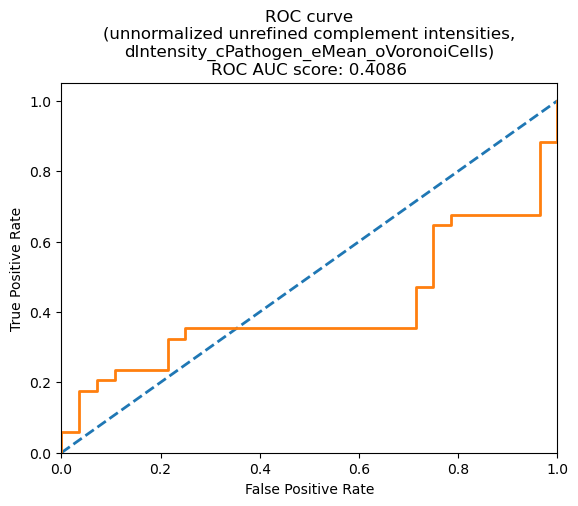

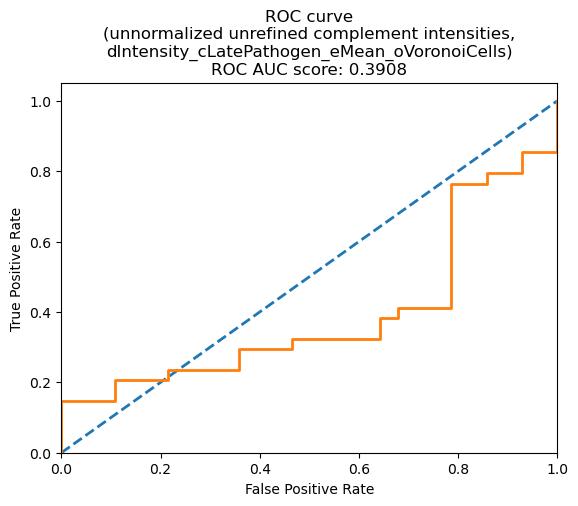

In [31]:
# In the case of unnormalized and unrefined intensity values, only one
# ROC curve has to be generated, namely for the complement intensities
generate_ROC_curve(
    compl_unnorm_min_max_norm_ints_df,
    prot_label_df,
    feature_names_unnormalized,
    "unnormalized unrefined complement intensities",
    os.path.join(
        roc_curve_dir_name,
        four_hit_lists_approach_dir,
        unnorm_unrefined_ints_roc_dir
    )
)

#### Generating ROC Curves for IQM-Normalized Unrefined Intensity Values

In [27]:
# Create a directory for this type of intensities
iqm_norm_unrefined_ints_roc_dir = (
    "IQM-normalized_unrefined_intensity_values"
)

if not os.path.exists(
    os.path.join(
        roc_curve_dir_name,
        four_hit_lists_approach_dir,
        iqm_norm_unrefined_ints_roc_dir
    )
):
    os.makedirs(
        os.path.join(
            roc_curve_dir_name,
            four_hit_lists_approach_dir,
            iqm_norm_unrefined_ints_roc_dir
        )
    )

[[0.3697478991596639,
           FPR       TPR  Threshold
  0   0.000000  0.000000        inf
  1   0.000000  0.058824   0.895744
  2   0.035714  0.058824   0.805361
  3   0.035714  0.088235   0.799971
  4   0.142857  0.088235   0.776239
  5   0.285714  0.088235   0.774921
  6   0.285714  0.264706   0.741457
  7   0.321429  0.264706   0.739941
  8   0.321429  0.294118   0.731743
  9   0.392857  0.294118   0.716578
  10  0.392857  0.382353   0.702420
  11  0.428571  0.382353   0.699746
  12  0.428571  0.411765   0.691780
  13  0.571429  0.411765   0.687710
  14  0.571429  0.441176   0.686004
  15  0.642857  0.441176   0.685093
  16  0.642857  0.500000   0.681587
  17  0.714286  0.500000   0.673668
  18  0.785714  0.500000   0.666023
  19  0.785714  0.529412   0.664792
  20  0.857143  0.529412   0.664028
  21  0.857143  0.558824   0.662610
  22  0.892857  0.558824   0.661464
  23  0.892857  0.617647   0.652728
  24  0.892857  0.676471   0.651260
  25  0.964286  0.676471   0.646572
  26  

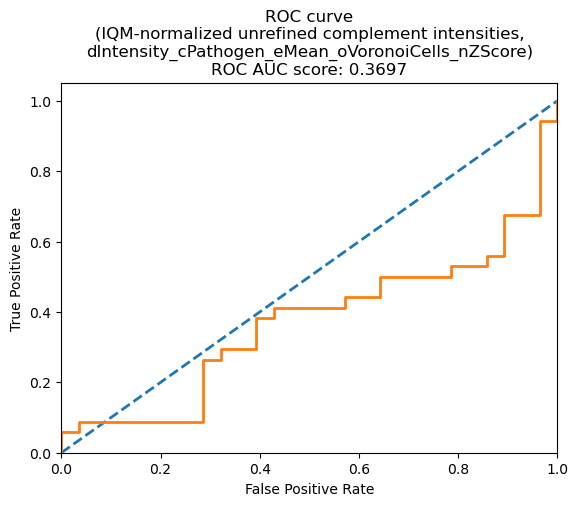

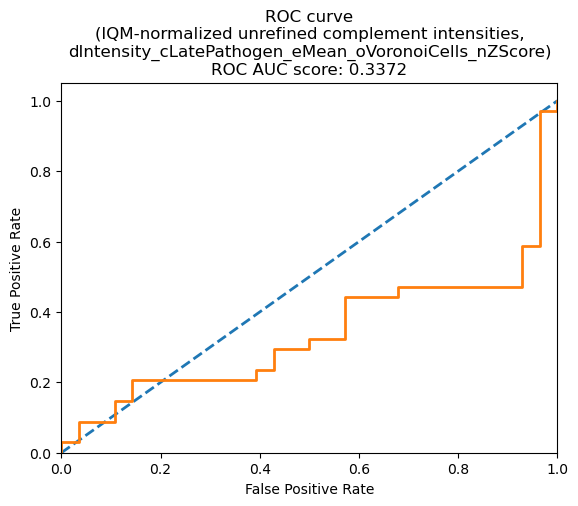

In [32]:
# Also in the case of IQM-normalized unrefined intensity values, only
# one ROC curve has to be generated for the complement intensities
generate_ROC_curve(
    compl_iqm_norm_min_max_norm_ints_df,
    prot_label_df,
    feature_names_normalized,
    "IQM-normalized unrefined complement intensities",
    os.path.join(
        roc_curve_dir_name,
        four_hit_lists_approach_dir,
        iqm_norm_unrefined_ints_roc_dir
    )
)

#### Generating ROC Curves for Unnormalized and Refined Intensity Values

In [28]:
# Create a directory for this type of intensities
unnorm_refined_ints_roc_dir = "unnormalized_refined_intensity_values"

if not os.path.exists(
    os.path.join(
        roc_curve_dir_name,
        four_hit_lists_approach_dir,
        unnorm_refined_ints_roc_dir
    )
):
    os.makedirs(
        os.path.join(
            roc_curve_dir_name,
            four_hit_lists_approach_dir,
            unnorm_refined_ints_roc_dir
        )
    )

In [34]:
# Now, in the case of refined intensities, four different ROC curves
# have to be generated, one for each refinement mode (max, mean, median,
# sum)
# Load the unnormalized and PPI-refined intensity values
compl_unnorm_ppi_refined_ints_list = []

for mode in refinement_modes:
    current_ints_path = os.path.join(
        four_hit_lists_approach_path,
        f"complement_unnorm_intensities_{mode}_refined.tsv"
    )

    current_ints_df = pd.read_csv(
        current_ints_path,
        sep="\t",
        index_col=["Name", "UniProt_IDs"]
    )

    compl_unnorm_ppi_refined_ints_list.append(current_ints_df)

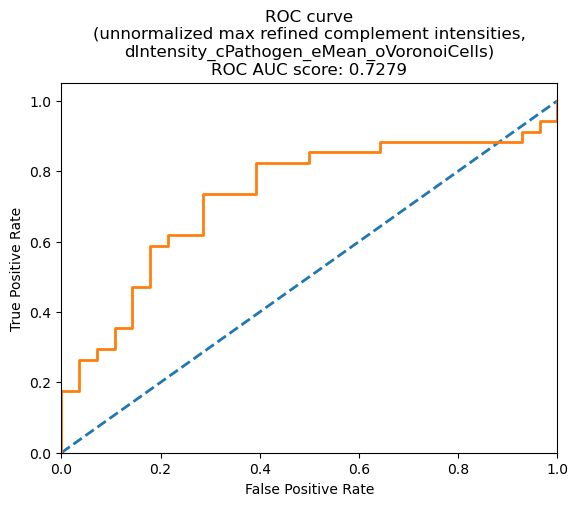

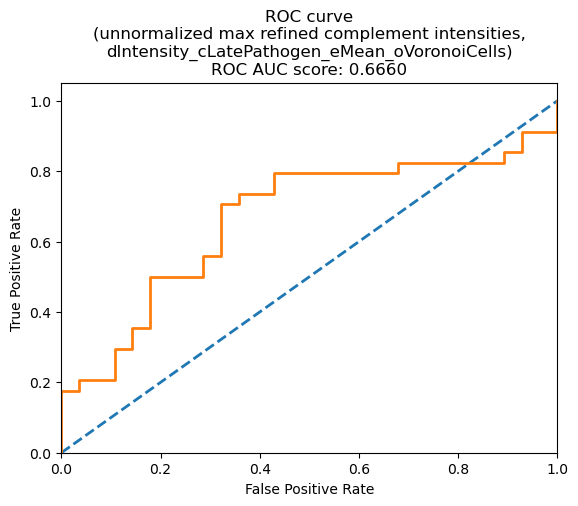

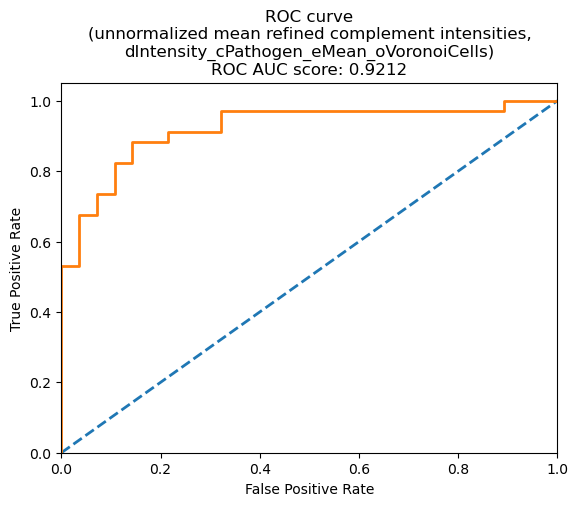

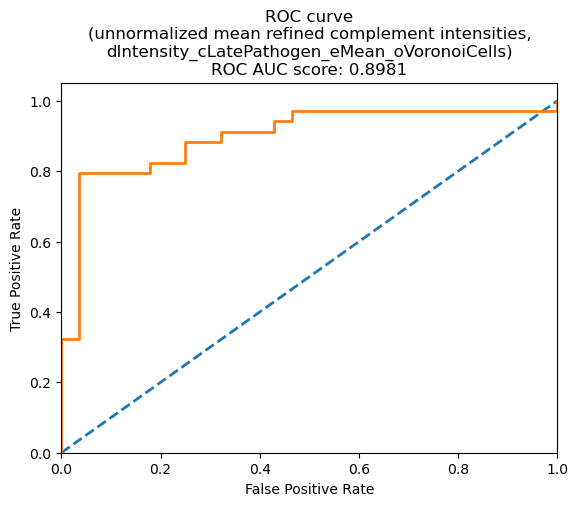

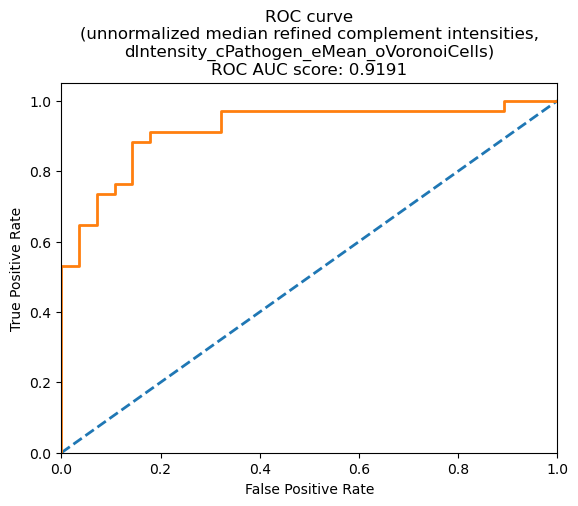

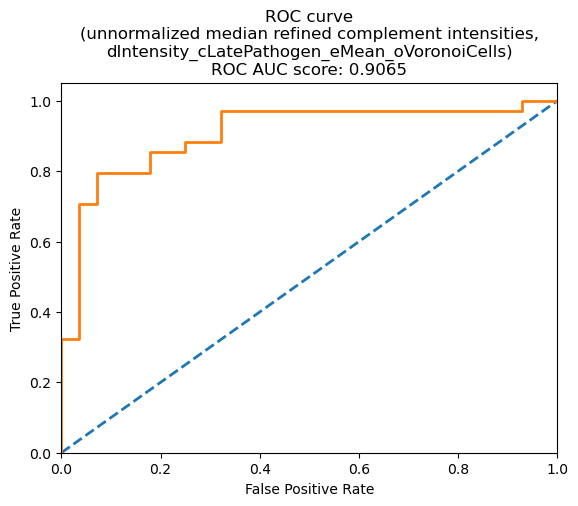

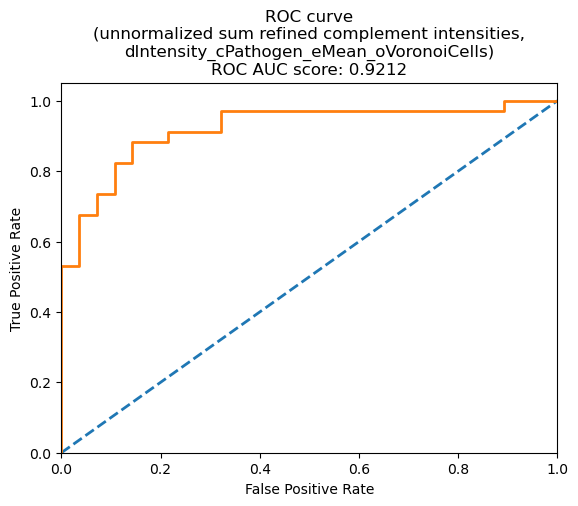

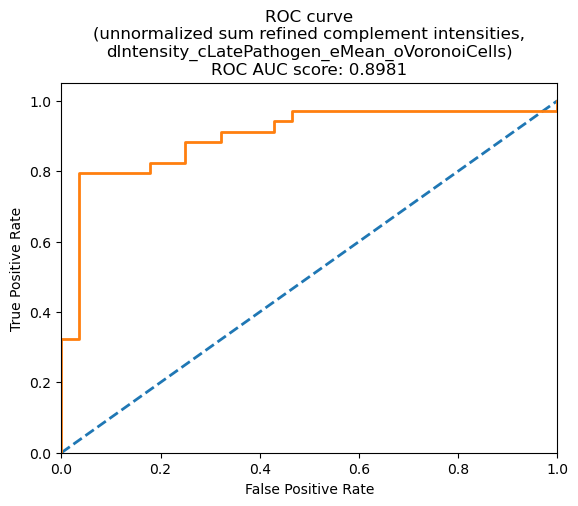

In [35]:
# In a for loop, jointly create subdirectories and generate the ROC
# curves
for mode, intensity_df in zip(
    refinement_modes, compl_unnorm_ppi_refined_ints_list
):
    # Subdirectory creation
    subdir_path = os.path.join(
        roc_curve_dir_name,
        four_hit_lists_approach_dir,
        unnorm_refined_ints_roc_dir,
        f"{mode}_refinement"
    )
    if not os.path.exists(subdir_path):
        os.makedirs(subdir_path)
    
    # ROC curve generation
    generate_ROC_curve(
        intensity_df,
        prot_label_df,
        feature_names_unnormalized,
        f"unnormalized {mode} refined complement intensities",
        subdir_path
    )

#### Generating ROC Curves for IQM-Normalized and Refined Intensity Values

In [29]:
# Create a directory for this type of intensities
iqm_norm_refined_ints_roc_dir = "IQM-normalized_refined_intensity_values"

if not os.path.exists(
    os.path.join(
        roc_curve_dir_name,
        four_hit_lists_approach_dir,
        iqm_norm_refined_ints_roc_dir
    )
):
    os.makedirs(
        os.path.join(
            roc_curve_dir_name,
            four_hit_lists_approach_dir,
            iqm_norm_refined_ints_roc_dir
        )
    )

In [36]:
#  Load the IQM-normalized and PPI-refined intensity values
compl_iqm_norm_ppi_refined_ints_list = []

for mode in refinement_modes:
    current_ints_path = os.path.join(
        four_hit_lists_approach_path,
        f"complement_IQM-normalized_intensities_{mode}_refined.tsv"
    )

    current_ints_df = pd.read_csv(
        current_ints_path,
        sep="\t",
        index_col=["Name", "UniProt_IDs"]
    )

    compl_iqm_norm_ppi_refined_ints_list.append(current_ints_df)

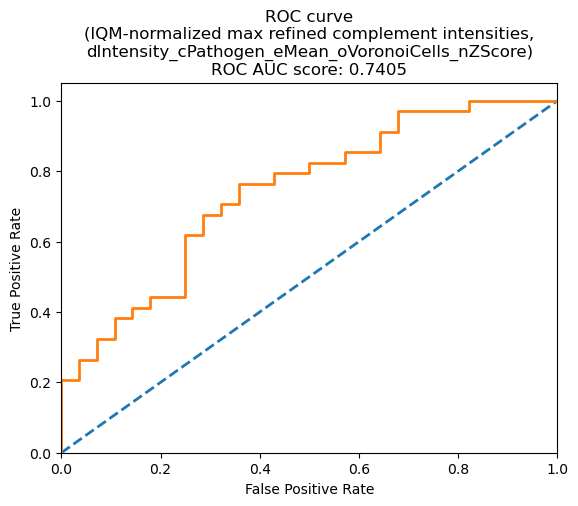

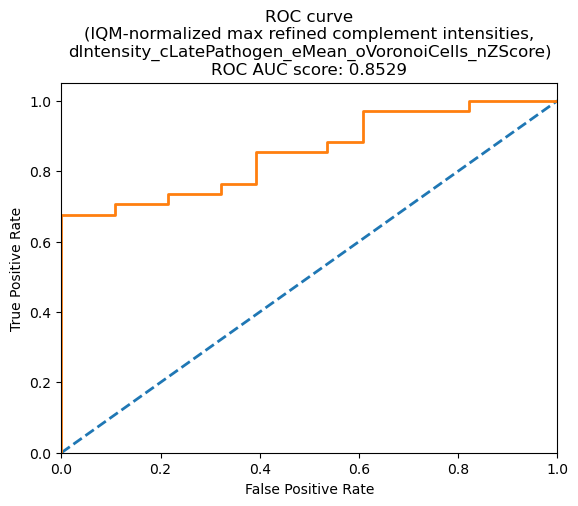

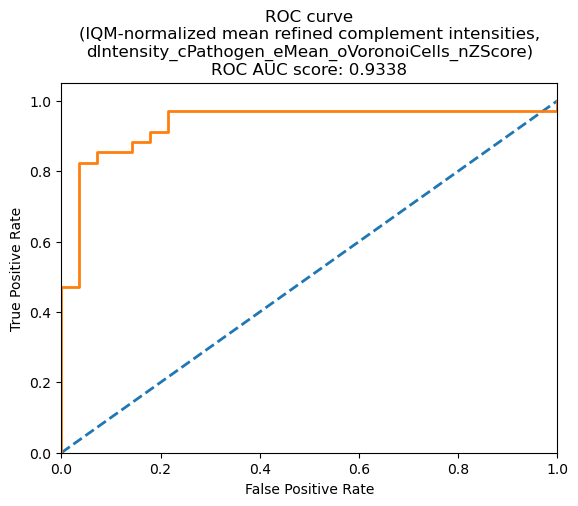

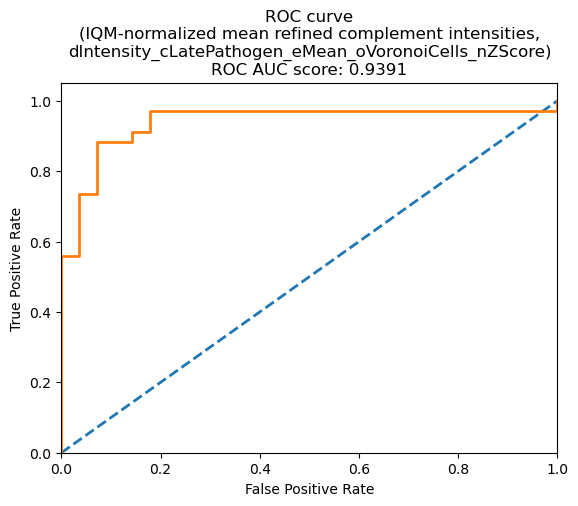

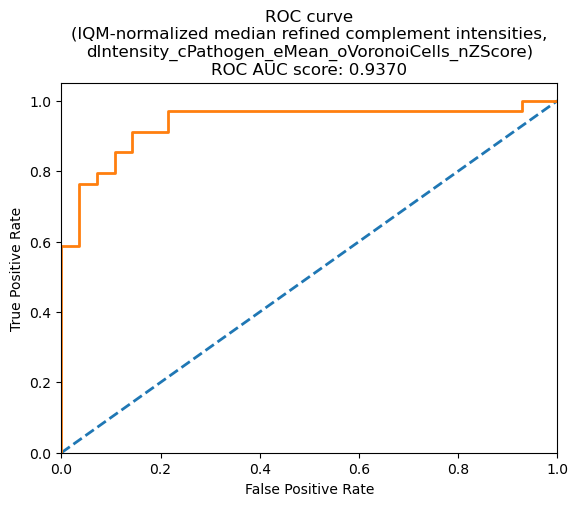

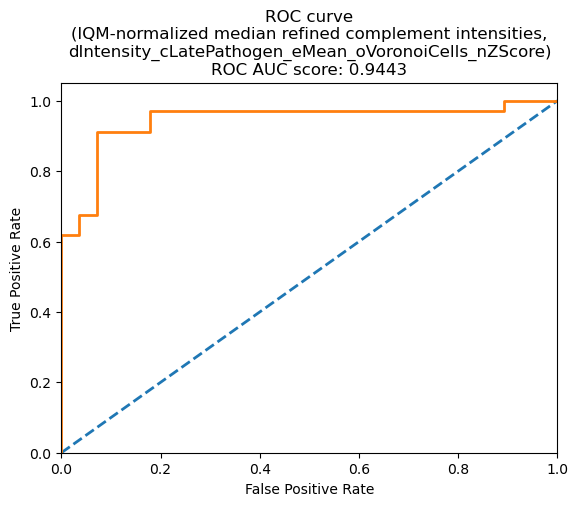

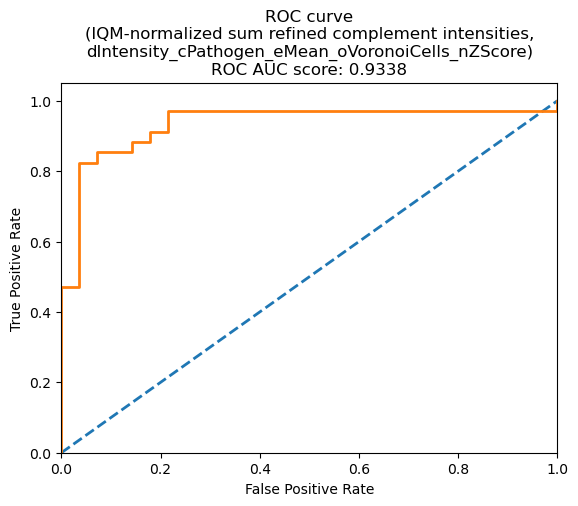

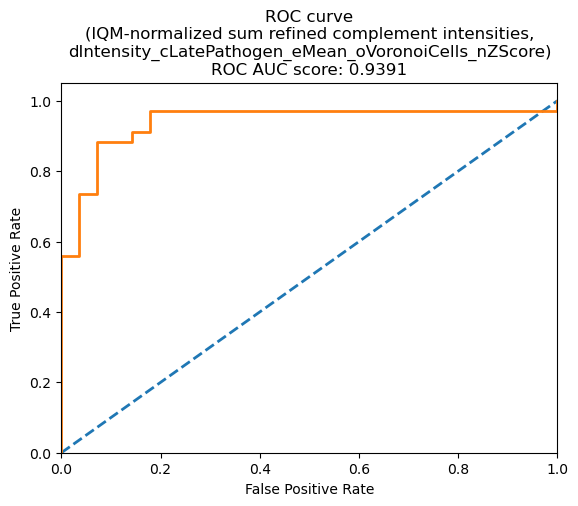

In [38]:
# In a for loop, jointly create subdirectories and generate the ROC
# curves
for mode, intensity_df in zip(
    refinement_modes, compl_iqm_norm_ppi_refined_ints_list
):
    # Subdirectory creation
    subdir_path = os.path.join(
        roc_curve_dir_name,
        four_hit_lists_approach_dir,
        iqm_norm_refined_ints_roc_dir,
        f"{mode}_refinement"
    )
    if not os.path.exists(subdir_path):
        os.makedirs(subdir_path)

    # ROC curve generation
    generate_ROC_curve(
        intensity_df,
        prot_label_df,
        feature_names_normalized,
        f"IQM-normalized {mode} refined complement intensities",
        subdir_path
    )